# Optimal POVM

One can open this tutorial in Google Colab (is recommended)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LuchnikovI/QGOpt/blob/master/docs/source/optimal_povm.ipynb)

In the following tutorial, we show how to perform optimization over the manifold of different POVMs by using QGOpt library. It is known that measurements of a qubit induced by tetrahedral POVM allow reconstructing unknown qubit state with a minimal variance if there is no prior knowledge about qubit state. Let us show it using numerical optimization over the manifold of different POVMs.
In the beginning, let us import some libraries.

In [ ]:
import tensorflow as tf  # tf 2.x
import matplotlib.pyplot as plt
import math

try:
    import QGOpt as qgo
except ImportError:
    !pip install git+https://github.com/LuchnikovI/QGOpt@Dev
    import QGOpt as qgo

# Fix random seed to make results reproducable.
tf.random.set_seed(42)

## Prior information about a quantum state

Here we generate prior information about a quantum state we want to measure. We represent a prior probability distribution over quantum state approximately, by using a set of samples from a distribution. Since tetrahedral POVM is optimal when there is no prior information about a state, we consider uniform distribution across Bloch ball.

In [2]:
#=======================================================================#
num_of_samples = 10000  # number of samples representing prior knowledge
#=======================================================================#

# Pauli matrices
sigma_x = tf.constant([[0, 1], [1, 0]], dtype=tf.complex128)
sigma_y = tf.constant([[0 + 0j, -1j], [1j, 0 + 0j]], dtype=tf.complex128)
sigma_z = tf.constant([[1, 0], [0, -1]], dtype=tf.complex128)

# All Pauli matrices in one tensor of shape (3, 2, 2)
sigma = tf.concat([sigma_x[tf.newaxis],
                   sigma_y[tf.newaxis],
                   sigma_z[tf.newaxis]], axis=0)

# Set of points distributed uniformly across Bloch ball
x = tf.random.normal((num_of_samples, 3), dtype=tf.float64)
x = x / tf.linalg.norm(x, axis=-1, keepdims=True)
x = tf.cast(x, dtype=tf.complex128)
u = tf.random.uniform((num_of_samples, 1), maxval=1, dtype=tf.float64)
u = u ** (1 / 3)
u = tf.cast(u, dtype=tf.complex128)
x = x * u

# Set of density matrices distributed uniformly across Bloch ball
# (prior information)
rho = 0.5 * (tf.eye(2, dtype=tf.complex128) + tf.tensordot(x, sigma, axes=1))

## POVM optimization

Here we search optimal POVM via minimizing the variance of a posterior distribution over density matrices.

The POVMs manifold is imlemented differently in comparison with other manifolds. Any POVM $\{M_\alpha\}_{\alpha=1}^N$ is represented by a set of matrices $\{A_\alpha\}_{\alpha=1}^N$, where $M_\alpha = A_\alpha A^\dagger_\alpha$. Since there is an equivalence relation $A_\alpha \sim A_\alpha Q_\alpha$, where $\{Q_\alpha\}_{\alpha=1}^N$ is a set of arbitrary unitary matrices, optimization is performed on the quotient manifold eliminating this simmetry. The corresponding quotient geometry is described in

Yatawatta, S. (2013, May). Radio interferometric calibration using a Riemannian manifold. In 2013 IEEE International Conference on Acoustics, Speech and Signal Processing (pp. 3866-3870). IEEE.

In [10]:
#=========================#
lr = 0.03  # learning rate
#=========================#

#  Manifold of different POVMs
m = qgo.manifolds.POVM()
# Initial parametrization of POVM
A = m.random((4, 2, 2), dtype=tf.complex128)
# Real representtion of A
A = qgo.manifolds.complex_to_real(A)
# tf.Variable to be tuned
A = tf.Variable(A)

# Riemannian Adam optimizer
opt = qgo.optimizers.RAdam(m, lr)

# Optimization loop
for i in range(1000):
    with tf.GradientTape() as tape:

        # Complex representation of parametrization
        Ac = qgo.manifolds.real_to_complex(A)
        # POVM
        povm = Ac @ tf.linalg.adjoint(Ac)
        # Inverce POVM
        povm_inv = tf.linalg.inv(tf.reshape(povm, (4, 4)))
        # Matrix T maps probability vector to four real parameters representing
        # a quantum state (equivalent to inverse POVM)
        T = tf.concat([tf.math.real(povm_inv[0, tf.newaxis]),
                        tf.math.real(povm_inv[3, tf.newaxis]),
                        tf.math.real(povm_inv[2, tf.newaxis]),
                        tf.math.imag(povm_inv[2, tf.newaxis])], axis=0)

        # POVM maps a quantum state to probability vector
        p = tf.tensordot(rho, povm, axes=[[2], [1]])
        p = tf.transpose(p, (0, 2, 1, 3))
        p = tf.math.real(tf.linalg.trace(p))

        # Covariance matrix of a reconstructed density matrix
        cov = -p[:, tf.newaxis] * p[..., tf.newaxis]
        cov = cov + tf.linalg.diag(p ** 2)
        cov = cov + tf.linalg.diag(p * (1 - p))
        cov = tf.tensordot(T, cov, [[1], [1]])
        cov = tf.tensordot(cov, T, [[2], [1]])
        cov = tf.transpose(cov, (1, 0, 2))

        # Covariance matrix avaraged over prior distribution
        av_cov = tf.reduce_mean(cov, axis=0)

        # loss function (log volume of Covariance matrix)
        loss = tf.reduce_sum(tf.math.log(tf.linalg.svd(av_cov)[0][:-1]))
    grad = tape.gradient(loss, A)  # gradient
    opt.apply_gradients(zip([grad], [A]))  # optimization step

## Validation

Here we check a resulting POVM. For tetrahedral POVM one has the following relation ${\rm Tr}\left(M^\alpha M^\beta\right) = \frac{2\delta_{\alpha\beta} + 1}{12}$. One can see, that this relation is almost true for a resulting POVM. The small error appears due to the approximate averaging.

<tf.Tensor: shape=(4, 4), dtype=float64, numpy=
array([[0.25003257, 0.08331541, 0.08331288, 0.08337171],
       [0.08331541, 0.25074221, 0.08337179, 0.08331225],
       [0.08331288, 0.08337179, 0.25007641, 0.08331532],
       [0.08337171, 0.08331225, 0.08331532, 0.24915009]])>

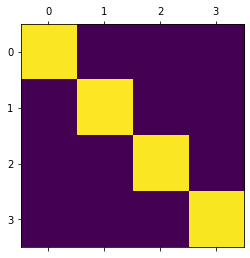

In [20]:
cross = tf.tensordot(povm, povm, [[2], [1]])
cross = tf.transpose(cross, (0, 2, 1, 3))
cross = tf.linalg.trace(cross)
cross = tf.math.real(cross)
plt.matshow(cross)
cross